In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta
# import filtering
import numpy as np
import dask
from dask.distributed import Client,default_client
import xrft
import eofs

client = tt.startdask()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43795 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:36515' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43795/status,
Dashboard: /proxy/43795/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36515,Workers: 7
Dashboard: /proxy/43795/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:35271,Total threads: 4
Dashboard: /proxy/34055/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:38213,


## Solve system:

$ \huge f(t) = t_0 + \sum (C_n \cos(\omega t_i) + S_n \sin(\omega t_i)) $

1.1469251135295397 3.5128828066464437


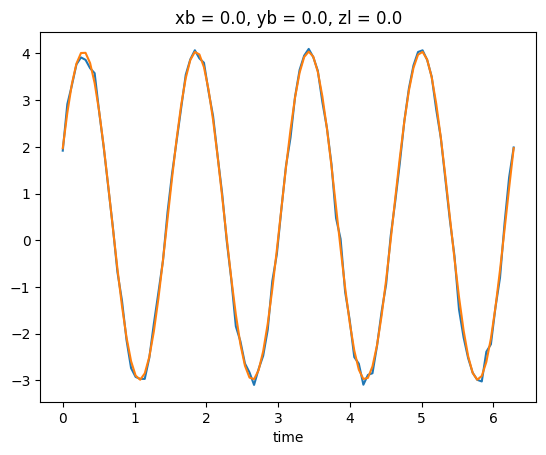

In [56]:
t = np.zeros(100) + 0.5 + 0.1 * np.random.randn(100)
AngFreq = 4
phases = [0,0.45,0.9,1.54,5.43]

for phase in phases:
    # plt.plot(t)
    t += np.sin(AngFreq * np.linspace(0,2 * np.pi,100) + phase)


# Reshape the 1D array to (100, 1, 1)
reshaped_t = np.reshape(t, (100, 1, 1,1))

# Repeat the values along the second and third axes
t = np.tile(reshaped_t, (1, 10, 10,10))


data = xr.DataArray(t, dims=['time',"xb","yb","zl"], 
                    coords={
                        'time': np.linspace(0,2*np.pi,100),
                        "xb":np.linspace(0,1,10),
                        "yb":np.linspace(0,1,10),
                        "zl":np.linspace(0,1,10)}) 

def harmonic_analysis(data):
    data = data.transpose("time","xb","yb","zl")
    coeff_matrix = np.zeros((len(data.time), 3))
    coeff_matrix[:,0] = 1
    coeff_matrix[:,1] = np.cos(AngFreq * data.time)
    coeff_matrix[:,2] = np.sin(AngFreq * data.time)
    coeff_matrix

    def ls(timeseries):
        t0,C,S = np.linalg.lstsq(coeff_matrix, timeseries, rcond=None)[0]
        phase = np.arctan2(S,C)
        amp = np.sqrt(C**2 + S**2)
        return amp,phase
    out = xr.DataArray(
        np.apply_along_axis(ls,0,data),
        dims = ["amp+phase","xb","yb","zl"],
        coords = {"amp+phase": ["amp","phase"],"xb":data.xb,"yb":data.yb,"zl":data.zl}
    )
    
    
    return out

data[:,0,0,0].plot()
plt.plot(data.time,t0 + C * np.cos(AngFreq * data.time) + S * np.sin(AngFreq * data.time))
phase = np.arctan2(S,C)
amp = np.sqrt(C**2 + S**2)
print(phase,amp)

In [6]:
data = tt.collect_data(exptname="full-20",rawdata = ["v","u"],timerange = (46861 - 100,46861 + 100),chunks = {"xb":-1,"yb":-1,"zl":1,"time":-1}).persist()
data= data.chunk({"time":-1})
# newdata = (data.u.rename("data").expand_dims({"var":2},-1) * 0).rename({"zl":"depth"})
# newdata[:,:,:,:,0] = data.u.values[:,:,:,:]
# newdata[:,:,:,:,1] = data.v.values[:,:,:,:]

# newdata_filtered = xr.merge(
#     [
#         tt.m2filter(data.u.unify_chunks()).rename("u").persist(),
#         tt.m2filter(data.v.unify_chunks()).rename("v").persist()
#     ]
# )

loading v...	done.
loading u...	done.


In [7]:
from eofs.standard import Eof

def eof_decomp_propagIT(data):

    '''

    decomposes input data into horizontal EOFs and vertical PCs till a specific depth and calculates variance fractions

    uses package: eofs.standard

    

    returns:

    xarray of EOFs (1 to 10), xarray of PCs (1 to 10) and variance fractions

    

    make sure data has dim depth and not lev!

    '''

    # level-index till which we perform the EOF-analysis

    crop = 70

    # data 

    data_cropped = data.isel(zl=slice(0,crop))

    print('data cropped till levidx',crop)

    # EOF and PC solver

    solver = Eof(data_cropped.values)

    E = solver.eofs(eofscaling=2, neofs=10) # scaling=2 EOFs are multiplied by the square-root of their eigenvalues

    P = solver.pcs(pcscaling=1, npcs=10) # scaling=1 PCs are divided by the square-root of their eigenvalues

    #depths_crop = depths.isel(depth=slice(0,crop))

    print('EOFs and PCs calculated. EOFs shape:',E.shape)

    # variance_fractions

    v = solver.varianceFraction(neigs=10)

    print('variance fractions calculated')

    # convert E and P to xarrays

    E = xr.DataArray(E,dims = ('eofs','yb','xb','var'),coords = {'eofs':['1','2','3','4','5','6','7','8','9','10'],'lat':data.lat,'lon':data.lon,'var':['Acos','Asin']})

    P = xr.DataArray(P,dims = ('zl','PCs'),coords = {'zl':np.arange(0,crop),'PCs':['1','2','3','4','5','6','7','8','9','10']})

    return E, P, v


# Data prep:

def prepdataforeof(A,phi):

    '''

    amplitude: A(x,y,z) from harmonic analysis

    phase: \phi(x,y,z) from harmonic analysis

    calculates the terms A(x,y,z)cos(\phi(x,y,z)) and A(x,y,z)sin(\phi(x,y,z))

    then concatinates and transposes the result, so it can be used for eof-decomposition

    '''

    Acos = A * np.cos(np.deg2rad(phi))

    Asin = A * np.sin(np.deg2rad(phi))

    

    dataforeof = xr.concat([Acos,Asin],dim='var')

    # Below var might be a coorinate distinguishing the variable?
    dataforeof = dataforeof.transpose('zl','yb','xb','var')
    # dataforeof = dataforeof.transpose('zl','yb','xb','time')

    

    return dataforeof


def harmonic_analysis(data,freq = 2 * np.pi / (360 / 28.984104)):
    data = data.transpose("time","xb","yb","zl")
    coeff_matrix = np.zeros((len(data.time), 3))
    coeff_matrix[:,0] = 1
    coeff_matrix[:,1] = np.cos(freq * data.time)
    coeff_matrix[:,2] = np.sin(freq * data.time)
    coeff_matrix

    def ls(timeseries):
        t0,C,S = np.linalg.lstsq(coeff_matrix, timeseries, rcond=None)[0]
        phase = np.arctan2(S,C)
        amp = np.sqrt(C**2 + S**2)
        return amp,phase
    out = np.apply_along_axis(ls,0,data)
    amp = out[0,:,:,:]
    phase = out[1,:,:,:]

    amp = xr.DataArray(
        out[0,:,:,:],
        dims = ["xb","yb","zl"],
        coords = {"xb":data.xb,"yb":data.yb,"zl":data.zl}
    ).rename("amp")
    phase = xr.DataArray(
        out[1,:,:,:],
        dims = ["xb","yb","zl"],
        coords = {"xb":data.xb,"yb":data.yb,"zl":data.zl,"lat":data.lat,"lon":data.lon}
    ).rename("phase")
    
    
    return xr.merge([amp,phase])

a = harmonic_analysis(data.u)
b = prepdataforeof(a.amp,a.phase)
c = eof_decomp_propagIT(b)

data cropped till levidx 70
EOFs and PCs calculated. EOFs shape: (10, 101, 376, 2)
variance fractions calculated


In [8]:
c

(<xarray.DataArray (eofs: 10, yb: 101, xb: 376, var: 2)>
 array([[[[ 4.73868418e-03, -1.38464443e-04],
          [ 5.93950920e-03, -2.21732534e-04],
          [ 5.27095400e-03, -1.96033521e-04],
          ...,
          [-2.05749430e-02, -1.46166502e-03],
          [-2.75017778e-02, -1.66961216e-03],
          [-3.18303143e-02, -1.90615477e-03]],
 
         [[ 5.83566935e-03, -1.70058326e-04],
          [ 5.35411879e-03, -1.92500726e-04],
          [ 1.07739946e-03, -6.17223797e-05],
          ...,
          [-3.89921721e-02, -2.09989846e-03],
          [-3.87693003e-02, -2.11501670e-03],
          [-3.68556764e-02, -2.04168935e-03]],
 
         [[ 7.86422197e-03, -2.32412668e-04],
          [ 2.92690761e-03, -1.02844611e-04],
          [-5.02096539e-03,  1.42789736e-04],
          ...,
 ...
          ...,
          [            nan,             nan],
          [            nan,             nan],
          [            nan,             nan]],
 
         [[ 0.00000000e+00,  0.00000000e+

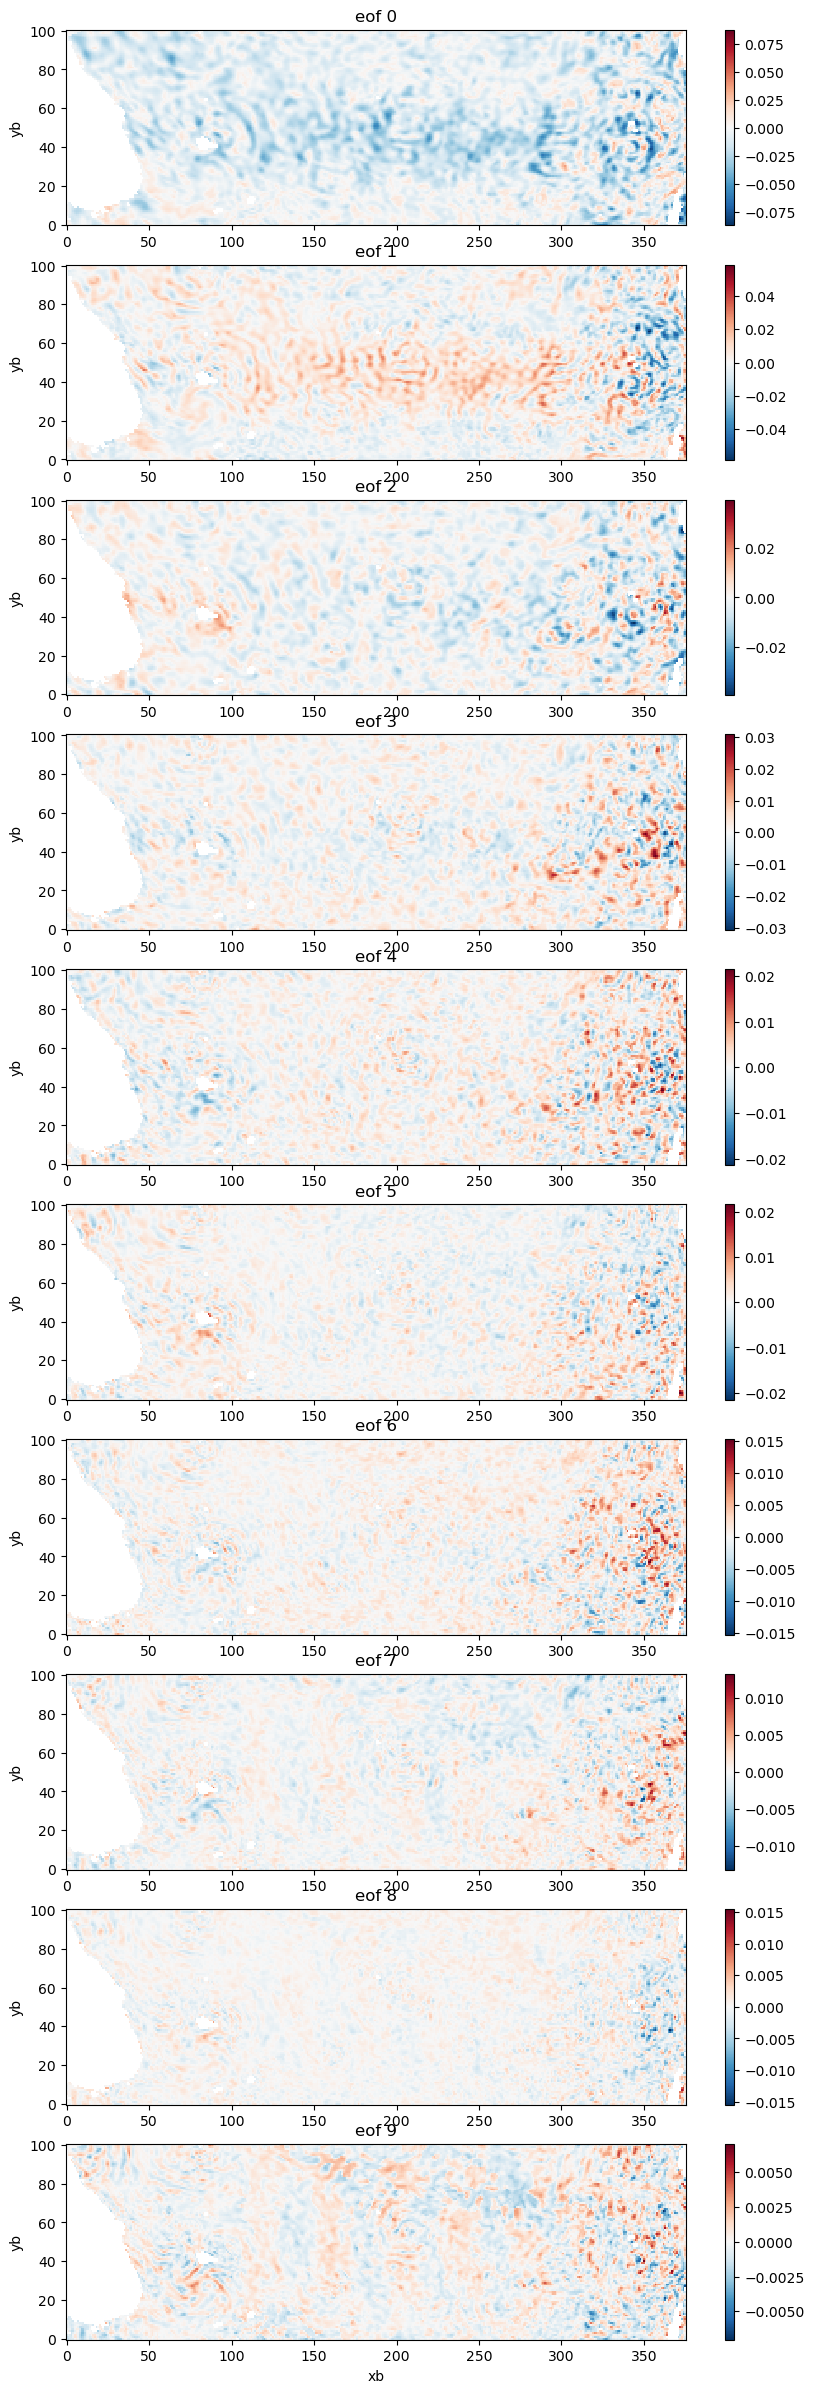

2024-04-26 21:12:20,004 - tornado.application - ERROR - Uncaught exception GET /status/ws (::1)
HTTPServerRequest(protocol='http', host='localhost:8888', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/tornado/websocket.py", line 937, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/tornado/web.py", line 3290, in wrapper
    return method(self, *args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


In [10]:
# 70 layers, eddy, averaged over two tidal periods

fig,ax = plt.subplots(10,figsize= (10,30))
for i in range(10):
    # np.log((out_u[0]**2 + out_v[0]**2)).isel(eofs=i,var = 0).mean("time").plot(ax = ax[i])
    (c[0]).isel(eofs=i,var = 0).plot(ax = ax[i])
    ax[i].set_title(f"eof {i}")
    if i != 9:
        ax[i].set_xlabel("")

# fig.suptitle